In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import gc
import lightgbm as lgb
from sklearn.metrics import precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
from itertools import combinations

# Prepare data

In [2]:
hdf_path = '../derived_data/source.hdf'

In [3]:
%%time
train = pd.read_hdf(hdf_path, key='train')

CPU times: user 434 ms, sys: 8.07 s, total: 8.5 s
Wall time: 38.5 s


In [4]:
train.loc[:, 'day'] = train.click_time.dt.day.astype('uint8')

In [5]:
train.loc[:, 'hour'] = train.click_time.dt.hour.astype('uint8')

In [6]:
train.head()

,ip,app,device,os,channel,click_time,is_attributed,day,hour
0,83230,3,1,13,379,2017-11-06 14:32:21,0,6,14
1,17357,3,1,19,379,2017-11-06 14:33:34,0,6,14
2,35810,3,1,13,379,2017-11-06 14:34:12,0,6,14
3,45745,14,1,13,478,2017-11-06 14:34:52,0,6,14
4,161007,3,1,13,379,2017-11-06 14:35:08,0,6,14


In [7]:
%%time
train.drop(['click_time'], axis=1, inplace=True)

CPU times: user 3.75 s, sys: 3.35 s, total: 7.1 s
Wall time: 2.14 s


In [8]:
gc.collect()

0

In [9]:
train = train.loc[train.day.isin([7, 8])].copy()

In [9]:
train = train.loc[train.day.isin([9])].copy()

In [10]:
gc.collect()

31

In [11]:
train.head()

,ip,app,device,os,channel,is_attributed,day,hour
131886953,201143,11,1,13,487,0,9,0
131886954,34684,2,1,13,469,0,9,0
131886955,207368,26,1,19,477,0,9,0
131886956,110176,18,1,8,121,0,9,0
131886957,109644,12,1,19,265,0,9,0


In [12]:
most_freq_hours_in_test_data = [4, 5, 9, 10, 13, 14]
least_freq_hours_in_test_data = [6, 11, 15]

In [13]:
train.loc[:, 'in_test_hh'] = (
    3 - 2*train.hour.isin(most_freq_hours_in_test_data) - 1*train.hour.isin(least_freq_hours_in_test_data)
).astype('uint8')

In [14]:
train.head()

,ip,app,device,os,channel,is_attributed,day,hour,in_test_hh
131886953,201143,11,1,13,487,0,9,0,3
131886954,34684,2,1,13,469,0,9,0,3
131886955,207368,26,1,19,477,0,9,0,3
131886956,110176,18,1,8,121,0,9,0,3
131886957,109644,12,1,19,265,0,9,0,3


In [15]:
gc.collect()

31

In [16]:
uint8_max = np.iinfo(np.uint8).max
uint16_max = np.iinfo(np.uint16).max
uint32_max = np.iinfo(np.uint32).max
def choose_int_type(n):
    if n <= uint8_max:
        return 'uint8'
    elif n <= uint16_max:
        return 'uint16'
    elif n <= uint32_max:
        return 'uint32'
    else:
        return 'uint64'

In [17]:
def process(dat, itercols, combo_max=None):
    combos = []
    if combo_max is None:
        combo_max = len(itercols)
    for i in range(combo_max):
        combos += list(combinations(itercols, i+1))
    for hour in ['hour', 'in_test_hh']:
        for combo in combos:
            print('Process {hour}, {combo}'.format(hour=hour, combo=combo))
            combo = list(combo)
            feats = ['day', hour] + combo
            gp = dat[feats].groupby(feats).size()
            int_type = choose_int_type(gp.max())
            gp = gp.astype(int_type)
            gp = gp.reset_index().rename(columns={0: '_'.join(['n'] + feats)})
            dat = dat.merge(gp, on=feats, how='left')
            del gp
            gc.collect()
    return dat

In [18]:
gc.collect()

0

In [19]:
train = process(train, ['ip', 'app', 'device', 'os', 'channel'], combo_max=2)

Process hour, ('ip',)
Process hour, ('app',)
Process hour, ('device',)
Process hour, ('os',)
Process hour, ('channel',)
Process hour, ('ip', 'app')
Process hour, ('ip', 'device')
Process hour, ('ip', 'os')
Process hour, ('ip', 'channel')
Process hour, ('app', 'device')
Process hour, ('app', 'os')
Process hour, ('app', 'channel')
Process hour, ('device', 'os')
Process hour, ('device', 'channel')
Process hour, ('os', 'channel')
Process in_test_hh, ('ip',)
Process in_test_hh, ('app',)
Process in_test_hh, ('device',)
Process in_test_hh, ('os',)
Process in_test_hh, ('channel',)
Process in_test_hh, ('ip', 'app')
Process in_test_hh, ('ip', 'device')
Process in_test_hh, ('ip', 'os')
Process in_test_hh, ('ip', 'channel')
Process in_test_hh, ('app', 'device')
Process in_test_hh, ('app', 'os')
Process in_test_hh, ('app', 'channel')
Process in_test_hh, ('device', 'os')
Process in_test_hh, ('device', 'channel')
Process in_test_hh, ('os', 'channel')


In [20]:
train.head()

,ip,app,device,os,channel,is_attributed,day,hour,in_test_hh,n_day_hour_ip,...,n_day_in_test_hh_ip_app,n_day_in_test_hh_ip_device,n_day_in_test_hh_ip_os,n_day_in_test_hh_ip_channel,n_day_in_test_hh_app_device,n_day_in_test_hh_app_os,n_day_in_test_hh_app_channel,n_day_in_test_hh_device_os,n_day_in_test_hh_device_channel,n_day_in_test_hh_os_channel
0,201143,11,1,13,487,0,9,0,3,70,...,26,499,75,2,484701,103999,46202,4575591,45996,9952
1,34684,2,1,13,469,0,9,0,3,54,...,28,337,41,2,2550798,552085,191254,4575591,302134,62632
2,207368,26,1,19,477,0,9,0,3,101,...,9,509,182,23,435656,115176,141539,5217777,826835,205731
3,110176,18,1,8,121,0,9,0,3,146,...,50,813,99,14,1937135,65358,355637,626314,521749,14106
4,109644,12,1,19,265,0,9,0,3,393,...,321,2326,763,93,2573155,642138,526726,5217777,639559,152975


In [21]:
gc.collect()

114

In [22]:
valid = train.loc[train.day == 7].copy()
train = train.loc[train.day == 8].copy()

In [23]:
gc.collect()

23

In [22]:
train.drop(['ip', 'day'], axis=1, inplace=True)

In [24]:
valid.drop(['ip', 'day'], axis=1, inplace=True)

In [25]:
gc.collect()

14

In [26]:
train.to_hdf('../derived_data/kaggle_populer.hdf', key='train', mode='w')
valid.to_hdf('../derived_data/kaggle_populer.hdf', key='valid', mode='w')

In [2]:
train = pd.read_hdf('../derived_data/kaggle_popular.hdf', key='train')
valid = pd.read_hdf('../derived_data/kaggle_populer.hdf', key='valid')

# Light GBM

In [23]:
train.columns

Index(['app', 'device', 'os', 'channel', 'is_attributed', 'hour', 'in_test_hh',
       'n_day_hour_ip', 'n_day_hour_app', 'n_day_hour_device', 'n_day_hour_os',
       'n_day_hour_channel', 'n_day_hour_ip_app', 'n_day_hour_ip_device',
       'n_day_hour_ip_os', 'n_day_hour_ip_channel', 'n_day_hour_app_device',
       'n_day_hour_app_os', 'n_day_hour_app_channel', 'n_day_hour_device_os',
       'n_day_hour_device_channel', 'n_day_hour_os_channel',
       'n_day_in_test_hh_ip', 'n_day_in_test_hh_app',
       'n_day_in_test_hh_device', 'n_day_in_test_hh_os',
       'n_day_in_test_hh_channel', 'n_day_in_test_hh_ip_app',
       'n_day_in_test_hh_ip_device', 'n_day_in_test_hh_ip_os',
       'n_day_in_test_hh_ip_channel', 'n_day_in_test_hh_app_device',
       'n_day_in_test_hh_app_os', 'n_day_in_test_hh_app_channel',
       'n_day_in_test_hh_device_os', 'n_day_in_test_hh_device_channel',
       'n_day_in_test_hh_os_channel'],
      dtype='object')

In [24]:
target = 'is_attributed'

In [25]:
predictors = train.columns.tolist()

In [26]:
predictors.remove(target)

In [27]:
predictors

['app',
 'device',
 'os',
 'channel',
 'hour',
 'in_test_hh',
 'n_day_hour_ip',
 'n_day_hour_app',
 'n_day_hour_device',
 'n_day_hour_os',
 'n_day_hour_channel',
 'n_day_hour_ip_app',
 'n_day_hour_ip_device',
 'n_day_hour_ip_os',
 'n_day_hour_ip_channel',
 'n_day_hour_app_device',
 'n_day_hour_app_os',
 'n_day_hour_app_channel',
 'n_day_hour_device_os',
 'n_day_hour_device_channel',
 'n_day_hour_os_channel',
 'n_day_in_test_hh_ip',
 'n_day_in_test_hh_app',
 'n_day_in_test_hh_device',
 'n_day_in_test_hh_os',
 'n_day_in_test_hh_channel',
 'n_day_in_test_hh_ip_app',
 'n_day_in_test_hh_ip_device',
 'n_day_in_test_hh_ip_os',
 'n_day_in_test_hh_ip_channel',
 'n_day_in_test_hh_app_device',
 'n_day_in_test_hh_app_os',
 'n_day_in_test_hh_app_channel',
 'n_day_in_test_hh_device_os',
 'n_day_in_test_hh_device_channel',
 'n_day_in_test_hh_os_channel']

In [28]:
categorical = ['app', 'device', 'os', 'channel', 'hour', 'in_test_hh']

In [29]:
gc.collect()

0

In [30]:
params = {
    'boosting_type': 'gbdt',  # I think dart would be better, but takes too long to run
    'drop_rate': 0.1,  # Rate at which to drop trees
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 7,  # Was 255: Reduced to control overfitting
    'max_depth': 4,  # Was 8: LightGBM splits leaf-wise, so control depth via num_leaves
    'min_child_samples': 100,
    'max_bin': 100,
    'subsample': 0.7,  # Was 0.7
    'subsample_freq': 1,
    'colsample_bytree': 0.7,
    'min_child_weight': 0,
    'subsample_for_bin': 200000,
    'min_split_gain': 0,
    'reg_alpha': 0,
    'reg_lambda': 0,
    'nthread': 8,
    'verbose': 0,
    'scale_pos_weight': 300
}

In [31]:
dtrain = lgb.Dataset(
    train.loc[:, predictors].values,
    label=train.loc[:, target].values,
    feature_name=predictors,
    categorical_feature=categorical
)

In [32]:
del train

In [33]:
gc.collect()

34

In [34]:
%%time
lgb_model = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=900,
    categorical_feature=categorical
)

CPU times: user 1h 56min 28s, sys: 8min 52s, total: 2h 5min 21s
Wall time: 31min 46s


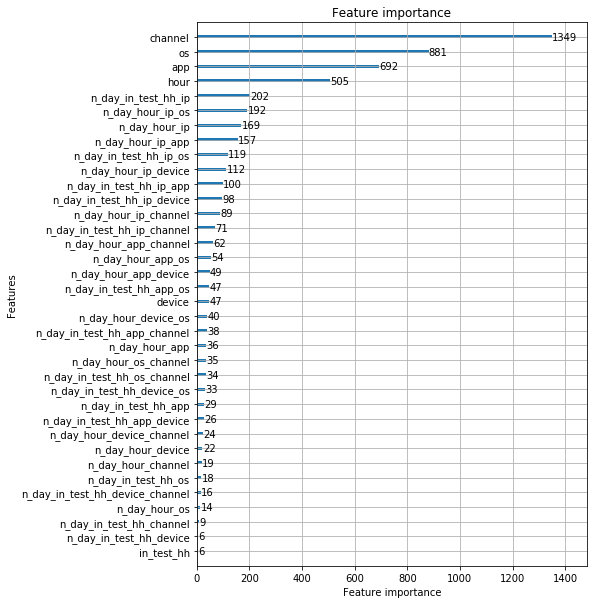

In [35]:
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_model, ax=ax, max_num_features=len(predictors))

In [40]:
pred = lgb_model.predict(valid.loc[:, predictors], num_iteration=lgb_model.best_iteration)

In [41]:
pred.shape

(59633310,)

In [42]:
valid.loc[:, 'pred'] = pred

In [43]:
valid.head()

,app,device,os,channel,is_attributed,hour,in_test_hh,n_day_hour_ip,n_day_hour_app,n_day_hour_device,...,n_day_in_test_hh_ip_device,n_day_in_test_hh_ip_os,n_day_in_test_hh_ip_channel,n_day_in_test_hh_app_device,n_day_in_test_hh_app_os,n_day_in_test_hh_app_channel,n_day_in_test_hh_device_os,n_day_in_test_hh_device_channel,n_day_in_test_hh_os_channel,pred
0,2,1,32,237,0,0,3,90,337709,3456007,...,937,8,173,3408505,34018,383064,249501,371440,3425,0.006935
1,3,1,25,424,0,0,3,328,718328,3456007,...,2588,212,27,5243862,125695,239596,683028,279272,6096,0.010294
2,8,2,13,145,0,0,3,788,95558,100959,...,554,1501,221,55162,171857,614183,221899,50858,160698,0.012833
3,2,1,13,122,0,0,3,47,337709,3456007,...,274,18,6,3408505,756654,309356,6533490,449202,101557,0.128455
4,15,1,8,245,0,0,3,153,307250,3456007,...,1149,5,34,3036324,88113,1260446,865747,1903508,57531,0.100233


In [44]:
roc_auc_score(valid.loc[:, target], pred)

0.9774249161184317

In [36]:
import pickle

In [37]:
with open('../results/kaggle_popular9.pickle', 'wb') as f:
    pickle.dump(lgb_model, f)